## Siamese Neural Networks 
### for Supervised Clustering of High Dimensional Spaces

In [1]:
!python -V
!which python

Python 3.6.10
/Users/seanmacrae/mobius/.venv/bin/python


In [2]:
sql = """
SELECT
  audience.*,
  latest.address,
  latest.city,
  latest.state,
  latest.zipcode,
  latest.county,
  latest.metroName,
  latest.longitude,
  latest.latitude,
  realEstateInvestor,
  personalInvestor
FROM `tranquil-garage-139216.people.audience_dbusa_features` dbusa
LEFT JOIN `tranquil-garage-139216.people.audience_20201012` audience ON audience.id = dbusa.id
LEFT JOIN `tranquil-garage-139216.people.latest` latest ON latest.id = audience.id
WHERE logsumHealthCause > 0 AND logAccreditedNetWorth > 6
"""

In [3]:
# !pip install loaderbot

In [4]:
cats = ['recentPurchaseDate',
            'recentDivorceDate',
            'recentDeathDate',
            'isBoatOwner',
            'isPlaneOwner',
            'recentPhilanthropicGiftDate',
            'recentFoundationAssociationDate',
            'isFoundationOfficer',
            'recentFoundationTrusteeDate',
            'hasFoundationAssociation',
            'hasCharityBoardMember',
            'hasCharityOfficer',
            'isMultiPropertyOwner',
            'isRentalPropertyOwner',
            'isHouseholdDebt',
            'recentPoliticalContributionDate',
            'isSmallBusinessOwner',
            'isCharityBoardMember',
            'isCharityOfficer',
            'hasTrust',
            'politicalDemocrat',
            'politicalRepublican',
            'politicalIndependent',
            'isSFROwner',
            'isCondoOwner',
            'isRuralResidenceOwner',
            'isArtsCause',
            'isEducationCause',
            'isEnvironmentalCause',
            'isAnimalCause',
            'isHealthCause',
            'isHumanServicesCause',
            'isInternationalCause',
            'isSocialBenefitCause',
            'isReligiousCause',
            'is990Donation',
            'isCoopDonation',
            'isFECContribution',
            'isStateContribution',
            'lux_athletic',
            'lux_flight',
            'lux_goods',
            'lux_travel',
            'zipcode',
            'realEstateInvestor',
            'personalInvestor']

dtype = {k: str for k in cats}

In [5]:
import loaderbot.big_query as bq
from google.cloud import bigquery, storage

bigquery_client = bigquery.Client(project="tranquil-garage-139216")
storage_client = storage.Client(project="tranquil-garage-139216")

raw_data = bq.query_table_and_cache(
            sql=sql,
            df_dtype=dtype,
            bigquery_client=bigquery_client,
            storage_client=storage_client,
    )

/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
raw_data.shape

(584245, 125)

In [7]:
raw_data.head()

,id,logNetWorth,logAccreditedNetWorth,recentPurchaseDate,recentDivorceDate,recentDeathDate,isBoatOwner,isPlaneOwner,recentPhilanthropicGiftDate,recentFoundationAssociationDate,...,address,city,state,zipcode,county,metroName,longitude,latitude,realEstateInvestor,personalInvestor
0,17dfe362f2a52fad7fc30688f883ed3c,6.317667,6.035153,0,0,0,0,0,0,0,...,11 WESTRIDGE DR,LAKE OSWEGO,OR,97034,Clackamas,"PORTLAND-VANCOUVER-BEAVERTON, OR-WA",-122.714792,45.393171,0,1
1,f155fadc922eef19d0d3933fe1a53162,6.390421,6.249058,0,0,0,0,0,0,0,...,116 AUGUSTA DR,BROUSSARD,LA,70518,Lafayette,"LAFAYETTE, LA",-91.946955,30.085969,1,1
2,6eb731db91258c929427e86bc5277ab7,6.490808,6.450590,1,0,0,0,0,0,0,...,13400 JUNEAU BLVD,ELM GROVE,WI,53122,Waukesha,"MILWAUKEE-WAUKESHA-WEST ALLIS, WI",-88.079144,43.045960,0,1
3,dedaab4d0d5c038715a1020260eeca79,6.455325,6.275680,0,0,0,0,0,0,0,...,278 FINCH LN,SAUNDERSTOWN,RI,02874,Washington,"PROVIDENCE-NEW BEDFORD-FALL RIVER, RI-MA",-71.476905,41.529689,0,0
4,afca333d749f7bcc869b3c9c11916733,6.661214,6.555541,0,0,0,0,0,0,0,...,1571 HICKS AVE,SAN JOSE,CA,95125,Santa Clara,"SAN JOSE-SUNNYVALE-SANTA CLARA, CA",-121.905612,37.296508,0,1


In [8]:
import numpy as np

def make_label(donation_amount):
    if donation_amount <= np.log10(1_000):
        return "low"
    elif (donation_amount > np.log10(1_000)) & (donation_amount <= np.log10(25_000)):
        return "mid"
    elif (donation_amount > np.log10(25_000)) & (donation_amount <= np.log10(80_000)):
        return "high"
    elif donation_amount > np.log10(80_000):
        return "windfall"
    
# engineer a donor label
raw_data["label"] = raw_data["logsumHealthCause"].apply(lambda x: make_label(x))

# shuffle the data
raw_data = raw_data.sample(frac=1, random_state=42)

In [9]:
from sklearn.model_selection import train_test_split

df, _ = train_test_split(
    raw_data,
    test_size=0.97,
    stratify=raw_data["label"])

In [10]:
df.shape

(17527, 126)

In [11]:
df["label"].value_counts() / len(df)

low         0.908085
mid         0.080790
high        0.005648
windfall    0.005477
Name: label, dtype: float64

## Tabular Learner

Before we train the Tabular Siamese Learner we will train baseline Tabular Learner for species classification... (why do we do this, exactly? can we just instantiate a Tabular Siamese Learner without a baseline Tabular Learner ???)

Ah yes, to init a new `TabularSiameseModel` we need to provide an `encoder` and `head` and the Tabular Learner will act as the `encoder` we init the `TabularSiameseModel` with.

In [12]:
df.head()

,id,logNetWorth,logAccreditedNetWorth,recentPurchaseDate,recentDivorceDate,recentDeathDate,isBoatOwner,isPlaneOwner,recentPhilanthropicGiftDate,recentFoundationAssociationDate,...,city,state,zipcode,county,metroName,longitude,latitude,realEstateInvestor,personalInvestor,label
548783,71a12f786b3141ff1b23cdff664c39a3,6.344622,6.235605,0,0,0,0,0,0,0,...,NORTHBROOK,IL,60062,Cook,"CHICAGO-NAPERVILLE-JOLIET, IL-IN-WI",-87.859722,42.129493,0,1,low
123648,2272c49da2f789b969ac4589d1909d3c,6.372025,6.236263,0,0,0,0,0,1,0,...,FAIRFAX,VA,22032,Fairfax,"WASHINGTON-ARLINGTON-ALEXANDRIA, DC-VA-MD-WV",-77.310502,38.823138,0,0,low
211779,ce4958885d4d93b58944c7d66aedc30e,6.782675,6.735207,0,0,0,0,0,0,0,...,MALIBU,CA,90265,Los Angeles,"LOS ANGELES-LONG BEACH-SANTA ANA, CA",-118.869788,34.037488,0,0,low
426230,324af10084db05e1d3b80810bc349d92,7.130590,7.070444,0,0,0,0,0,0,0,...,BOSTON,MA,02115,Suffolk,"BOSTON-CAMBRIDGE-QUINCY, MA-NH",-71.086326,42.351427,0,1,low
371950,1bc8a8515ea62df6d37325e0b9fd0aea,6.355048,6.075842,0,0,0,0,0,0,0,...,SCITUATE,MA,02066,Plymouth,"BOSTON-CAMBRIDGE-QUINCY, MA-NH",-70.718505,42.191649,0,1,low


In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"])

df = df_train.copy()

exclude_vars = ["id", 
                "longitude", 
                "latitude", 
                "label",
                "address",
                'logMaxDonationAmount',
                'logSumDonationAmount',
                'isHealthCause',
                'isCoopDonation',
                'logsumHealthCause',
                'logMaxDonationAmount_1year',
                'logSumDonationAmount_1year',
                'logsumCOOPDonation_1year',
                'logMaxDonationAmount_3year',
                'logSumDonationAmount_3year',
                'logsumCOOPDonation_3year',
                'logMaxDonationAmount_5year',
                'logSumDonationAmount_5year',
                'logsumCOOPDonation_5year']

In [14]:
from fastai.tabular.all import CategoryBlock
                                
y_names = ["label"]
y_block = CategoryBlock()

In [15]:
from mobius.utils import emb_sz_rule

cat_names = [x for x in df.select_dtypes(exclude=['int', 'float']).columns if x != y_names]
cat_names = [x for x in cat_names if x not in exclude_vars]

# calc embedding sizes for each categorical feature
emb_szs = {k: emb_sz_rule(len(df[k].unique())) for k in cat_names}
emb_szs

{'recentPurchaseDate': 2,
 'recentDivorceDate': 2,
 'recentDeathDate': 2,
 'isBoatOwner': 2,
 'isPlaneOwner': 2,
 'recentPhilanthropicGiftDate': 2,
 'recentFoundationAssociationDate': 2,
 'isFoundationOfficer': 2,
 'recentFoundationTrusteeDate': 2,
 'hasFoundationAssociation': 2,
 'hasCharityBoardMember': 2,
 'hasCharityOfficer': 2,
 'isMultiPropertyOwner': 2,
 'isRentalPropertyOwner': 2,
 'isHouseholdDebt': 2,
 'recentPoliticalContributionDate': 2,
 'isSmallBusinessOwner': 2,
 'isCharityBoardMember': 2,
 'isCharityOfficer': 2,
 'hasTrust': 2,
 'politicalDemocrat': 2,
 'politicalRepublican': 2,
 'politicalIndependent': 2,
 'isSFROwner': 2,
 'isCondoOwner': 2,
 'isRuralResidenceOwner': 2,
 'isArtsCause': 2,
 'isEducationCause': 2,
 'isEnvironmentalCause': 2,
 'isAnimalCause': 2,
 'isHumanServicesCause': 2,
 'isInternationalCause': 2,
 'isSocialBenefitCause': 2,
 'isReligiousCause': 2,
 'is990Donation': 2,
 'isFECContribution': 2,
 'isStateContribution': 2,
 'lux_athletic': 2,
 'lux_flig

In [16]:
import numpy as np

cont_names = [x for x in df.select_dtypes([np.number]).columns if x != y_names]
cont_names = [x for x in cont_names if x not in exclude_vars]
cont_names

['logNetWorth',
 'logAccreditedNetWorth',
 'logTotalHouseholdDebt',
 'recentSecTransactionAcquired',
 'recentSecTransactionDisposed',
 'primaryPropertyLoanToValue',
 'logPrimaryPropertyAvm',
 'femaleCount',
 'maleCount',
 'minHouseholdAge',
 'avgHouseholdAge',
 'maxHouseholdAge',
 'metroNameRank',
 'propertyCount',
 'logMaxPropertyAvm',
 'logSumPropertyAvm',
 'maxPropertySqft',
 'maxBedrooms',
 'primaryPropertySqft',
 'primaryPropertyYearsOwned',
 'minPropertyYearsOwned',
 'maxPropertyYearsOwned',
 'logsumArtsCause',
 'logsumEducationCause',
 'logsumEnvironmentalCause',
 'logsumAnimalCause',
 'logsumHumanServicesCause',
 'logsumInternationalCause',
 'logsumSocialBenefitCause',
 'logsumReligiousCause',
 'logsum990Donation',
 'logsumCOOPDonation',
 'logsumFECDonation',
 'logsumStateContribution',
 'logmax990Donation',
 'logmaxCOOPDonation',
 'logmaxFECDonation',
 'logmaxStateContribution',
 'countNumCharities',
 'logsumFECDonation_1year',
 'logsumStateContribution_1year',
 'countNumChari

/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


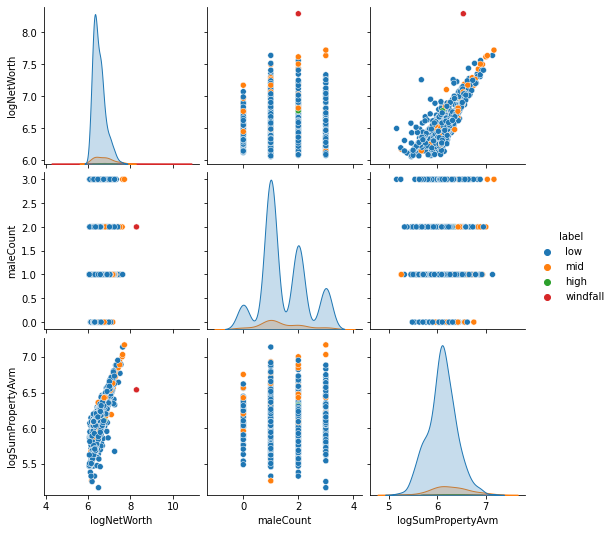

In [17]:
import seaborn as sns

sns.pairplot(df[["logNetWorth", "maleCount", "logSumPropertyAvm", "label"]].sample(frac=0.05), hue='label')

In [18]:
from fastai.tabular.all import (Categorify, CategoryBlock, FillMissing,
                                Normalize, TabDataLoader, TabularPandas,
                                tabular_config, tabular_learner)

procs = [FillMissing, Categorify, Normalize]

In [19]:
from fastai.data.core import range_of
from fastai.tabular.all import RandomSplitter, TrainTestSplitter

# # train/test split
# splits = RandomSplitter(valid_pct=0.20)(range_of(df))

splits = TrainTestSplitter(test_size=0.20, 
                           train_size=0.80, 
                           random_state=None, 
                           stratify=df["label"].values, 
                           shuffle=True)(range_of(df))

In [20]:
tabular_pandas = TabularPandas(
        df,
        procs=procs,
        cat_names=cat_names,
        cont_names=cont_names,
        y_names=y_names,
        y_block=y_block,
        splits=splits,
        device="cpu")

In [21]:
# from mobius.samplers import ImbalancedDatasetSampler

trn_dl = TabDataLoader(
    tabular_pandas.train,
    bs=128,
    shuffle=True,
    drop_last=True,)

val_dl = TabDataLoader(
    tabular_pandas.valid,
    bs=128,)

In [22]:
from fastai.data.core import DataLoaders

dls = DataLoaders(trn_dl, val_dl)

print("Sample batch:")
dls.one_batch()

Sample batch:


(tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 2, 2, 2],
         [2, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 2, 2, 2],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[-0.7489, -0.6708, -1.8228,  ..., -0.1186,  0.3982,  0.1915],
         [ 0.2100,  0.2127, -1.8228,  ..., -0.1186,  0.7242,  0.8002],
         [-0.9175, -0.7615,  0.1725,  ..., -0.1186, -0.9313, -0.6051],
         ...,
         [-0.9895, -0.8883, -1.8228,  ..., -0.1186,  0.3593,  0.6427],
         [-0.6184, -1.1151,  0.2949,  ..., -0.1186,  0.0525,  0.3059],
         [-1.1749, -1.1786,  0.4719,  ..., -0.1186, -0.2297, -3.3091]]),
 tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [2],
         [1],
         [1],
         [

In [23]:
from fastai.metrics import F1Score, Precision, Recall, accuracy

# load the tabular_pandas data through the tabular_learner
layers = [2048, 1024, 32, 2]

# tabular learner configuration
config = tabular_config(ps=[0.01, 0.01, 0.01, 0.01], embed_p=0.01)

# create tabular learner
learn = tabular_learner(
    dls,
    layers=layers,
    emb_szs=emb_szs,
    config=config,
    metrics=[accuracy,
             Precision(average='macro'),
             Recall(average='macro'),
             F1Score(average='macro')])

In [24]:
learn.fit_one_cycle(n_epoch=12)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.612821,1.521294,0.005388,0.002837,0.242647,0.005605,00:12
1,1.335796,1.137279,0.508399,0.246675,0.347807,0.185626,00:13
2,0.906886,0.744073,0.646593,0.238055,0.343630,0.207817,00:12
3,0.633802,0.571434,0.718859,0.240336,0.418732,0.224351,00:12
4,0.522711,0.543593,0.700792,0.244730,0.427560,0.222521,00:12
5,0.443668,0.473196,0.908716,0.477237,0.279412,0.290707,00:12
6,0.391121,0.413140,0.908082,0.352085,0.264619,0.264269,00:12
7,0.312457,0.329572,0.908082,0.227165,0.250000,0.238036,00:13
8,0.263149,0.305561,0.908082,0.227093,0.250000,0.237996,00:12
9,0.233312,0.292654,0.908082,0.227021,0.250000,0.237957,00:12


/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/seanmacrae/mobius/.venv/lib/python3.6/s

In [25]:
# lr_min, _ = learn.lr_find()
# learn.fit(n_epoch=5, lr=lr_min)

In [26]:
learn.export("tabular_learn.pkl")

In [27]:
from mobius.calibration import ModelWithTemperature

scaled_model = ModelWithTemperature(learn.model)
scaled_model.set_temperature(val_dl)
learn.model = scaled_model.model

Before temperature - NLL: 0.283, ECE: 0.027
Optimal temperature: 0.902
After temperature - NLL: 0.289, ECE: 0.033


In [28]:
# true species labels
y_true=learn.dls.valid.items["label"]

# model scores and species predictions
y_scores, *_ = learn.get_preds(dl=val_dl)
preds = np.argmax(y_scores, 1).numpy()

/Users/seanmacrae/mobius/.venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print("First 20 species labels and predictions")
list(zip(y_true, preds))[:10]

First 20 species labels and predictions


[(1, 1),
 (2, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 1),
 (1, 1)]

In [30]:
(y_true == preds).sum() / len(y_true)

0.9080824088748018

In [31]:
# TODO: update roc-it with MultiClassClassification...

# clf_metrics = BinaryClassification(
#     y_true=y_true, y_scores=y_scores)

# ths = clf_metrics.recall_curve(0.95)

# clf_metrics.plot_confusion_matrix(
#     ths=0.50,
#     normalize=None,
#     save_path=f'{hyperparams["artifact_dir"]}/cm.png')

# clf_metrics.plot_pr_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/pr_curve.png')

# clf_metrics.plot_roc_curve(
#     save_path=f'{hyperparams["artifact_dir"]}/roc_curve.png')

## Siamese Net

To init a new `TabularSiameseDataset` object, we only need a `tabular_pandas` object from the fast.ai library.

In [32]:
from mobius.datasets import TabularSiameseDataset

# sds = TabularSiameseDataset(tabular_pandas)
train_ds = TabularSiameseDataset(tabular_pandas.train)
valid_ds = TabularSiameseDataset(tabular_pandas.valid)

In [33]:
train_ds.__getitem__(10)

((tensor([   2,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             2,    2,    2,    2,    1,    1,    1,    1,    2,    1,    1,    2,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    2,
             2,    1,    1,    1,    1, 1195,   10, 1833,  177,  196,    2,    2,
             1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1,    1,    1]),
  tensor([-1.4902, -1.1278,  0.5676, -0.0691, -0.0564,  2.2607, -0.7294,  1.8221,
           0.6253, -0.8577, -0.2931,  0.3279,  0.3656,  0.7343, -1.5489, -0.6144,
          -0.0445, -0.0988, -0.0491, -1.5118, -1.2710, -1.0384, -0.1250, -0.3926,
          -0.3685, -0.1998, -0.4071, -0.0783, -0.2229, -0.1393, -0.0943, -0.7714,
           0.6602,  0.0983, -0.0943, -0.7673,  0.2412,  0.2185, -0.6556,  1.1605,
           1.9592, -0.3412,  0.0000,  0.9748,  0.6504, -0.6131, -0.0657,  0.8691,
           0.4593, -0.7894, -0.2610, -0.2456, -0.0

In [34]:
# experiment with larger batches
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=32, device='cpu', num_workers=0)

Siamese net encoder is the body of the Tabular net we just trained.

In [35]:
dls.one_batch()

((tensor([[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 2, 2, 2],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 2, 2, 2]]),
  tensor([[-0.2413, -0.2711,  0.7302,  ..., -0.1186,  0.3296,  0.5971],
          [-1.0342, -0.9465,  0.2902,  ..., -0.1186,  0.0403, -0.4967],
          [ 0.1300,  0.0362,  0.1265,  ..., -0.1186, -0.2386, -0.4721],
          ...,
          [-0.5358, -0.4389,  0.2988,  ..., -0.1186,  0.6352,  0.8511],
          [ 1.4310,  1.5400,  0.6094,  ..., -0.1186,  0.7707,  1.0062],
          [-1.2572, -1.0605,  0.4755,  ..., -0.1186,  0.3678,  0.5155]])),
 (tensor([[1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 2, 2, 2],
          [1, 1, 1,  ..., 1, 1, 1]]),
  tensor([[ 0.6025,  0.4762,  0.4341,  ..., -0.1186,  0.5617,  0.7102],
          [ 

In [36]:
import copy

encoder = copy.copy(learn)
encoder.model.layers = learn.model.layers[:-1]
encoder_model = encoder.model

We create a new head that doubles the input shape to the last layer of the trained Tabular net, since the loss function will now compare 2 penguins. The size of the output shape is set by...???

In [37]:
from fastai.layers import LinBnDrop

head = LinBnDrop(n_in=layers[-1]*2,
    n_out=16,  # size of output space
    bn=True,
    act=None)

In [38]:
from mobius.models import TabularSiameseModel

model = TabularSiameseModel(encoder_model, head)

In [39]:
from fastai.torch_basics import params
from mobius.losses import ContrastiveLoss

def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

def contrastive_loss_func(out, targ):
    return ContrastiveLoss(margin=0.66)(out, targ.long())

In [40]:
from fastai.learner import Learner

siamese_learner = Learner(dls,
    model,
    model_dir=".",
    loss_func=contrastive_loss_func,
    splitter=siamese_splitter)

In [41]:
# %debug
siamese_learner.freeze()
siamese_learner.fit_one_cycle(n_epoch=20)

epoch,train_loss,valid_loss,time
0,9.362355,3.130498,24:24
1,7.236290,1.899438,24:19
2,2.941417,0.649454,24:43
3,0.834170,0.149150,3:29:27
4,0.171487,0.019486,24:44
5,0.072723,0.006658,24:46
6,0.115786,0.000370,24:19
7,0.039890,-0.009746,24:23
8,-0.044158,-0.065414,24:17
9,-0.177993,-0.409494,24:50


In [42]:
# siamese_learner.unfreeze()
# lr_min, _ = siamese_learner.lr_find()
# siamese_learner.fit(n_epoch=5, lr=lr_min)

In [43]:
# siamese_learner.save("snn_margin_20")
# siamese_learner.export("snn_margin_10.pkl")

In [44]:
# from fastai.learner import load_learner

# snn_model = load_learner('snn_margin_20.pth', cpu=False)

In [45]:
# %debug
from tqdm import tqdm

train_encoded = list()
for i in tqdm(range(len(dls.train_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.train_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    train_encoded.append(p_encode)
    
ids = dls.train.get_idxs()
y_train_labels = dls.train.tabular_pandas["label"]

100%|██████████| 12619/12619 [38:58<00:00,  5.40it/s]


In [46]:
import torch
import pandas as pd

train_encoded_df = pd.DataFrame(torch.stack(train_encoded).squeeze())

In [47]:
train_encoded_df

,0,1
0,11.170471,0.0
1,11.046360,0.0
2,11.267647,0.0
3,10.559312,0.0
4,11.240452,0.0
...,...,...
12614,11.108839,0.0
12615,11.230120,0.0
12616,11.286786,0.0
12617,11.023884,0.0


In [48]:
# !pip install seaborn

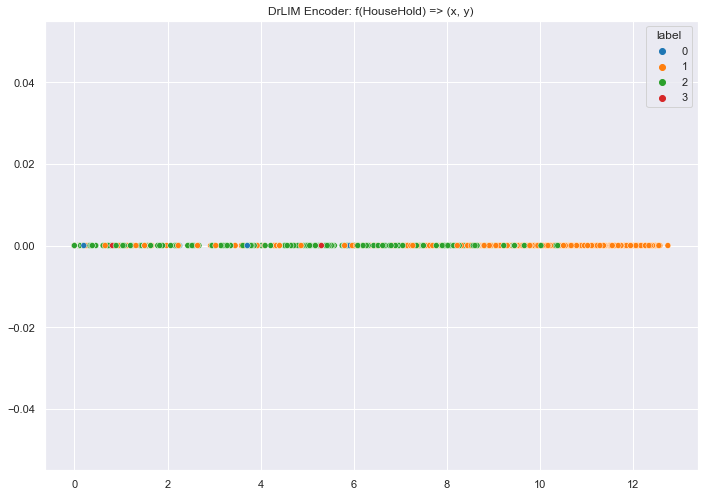

In [49]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(x=train_encoded_df[0].values,
                y=train_encoded_df[1].values,
                hue=y_train_labels, 
                legend='full', 
                palette="tab10").set_title('DrLIM Encoder: f(HouseHold) => (x, y)');

In [50]:
# train_encoded_df
# dls.train_ds.tabular_pandas

In [51]:
import seaborn as sns
from sklearn.manifold import TSNE
sns.set(rc={'figure.figsize':(11.7,8.27)})

tsne = TSNE()
encoded_train_tsne = tsne.fit_transform(train_encoded_df.values)

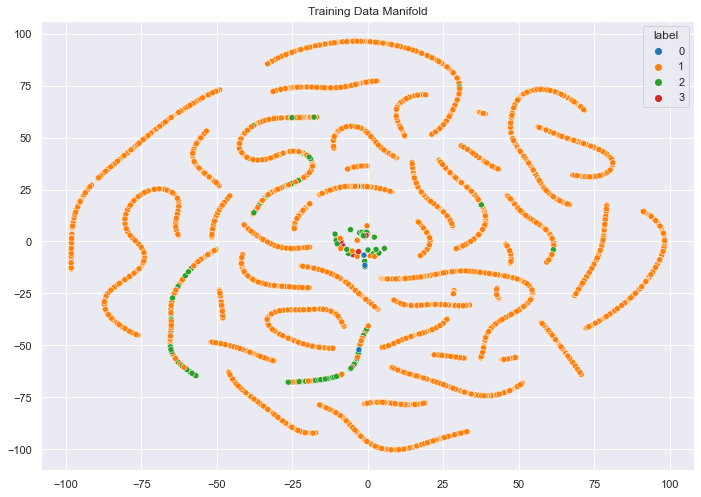

In [52]:
sns.scatterplot(x=encoded_train_tsne[:,0],
                y=encoded_train_tsne[:,1],
                hue=y_train_labels, 
                legend='full', 
                palette="tab10").set_title('Training Data Manifold');

In [53]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "max_depth":[3, 5, 8, 10],
    "n_estimators":[50, 100]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, scoring=f1, cv=5, n_jobs=-1)
clf.fit(train_encoded_df.values, y_train_labels)

print(clf.score(train_encoded_df.values, y_train_labels))
print(clf.best_params_)

0.5351595127783397
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


## Experiment: Clustering Approach

In [54]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# # TODO: grid search this...
# clustering = AgglomerativeClustering(
#     n_clusters=8, 
#     affinity="l1", 
#     linkage="complete").\
# fit(train_encoded_df.values)

# clustering.labels_

In [55]:
# res = pd.DataFrame(zip(y_train_labels, clustering.labels_), columns=["true", "pred"])

In [56]:
# res_counts = res.groupby(["true", "pred"]).apply(len).reset_index()
# res_counts.columns = ["true", "pred", "count"]

In [57]:
# # TODO: order the below for loops to start with largest clusters first
# res_counts

In [58]:
# cluster2label = dict()
# for pred in res_counts["pred"].unique():
#     thingy = res_counts[res_counts["pred"] == pred].sort_values("count", ascending=False)
    
#     for label in thingy["true"].values:
#         if label not in cluster2label.values():
#             cluster2label.update({pred: label})
    
# for pred in res_counts["pred"].unique():
#     if pred not in cluster2label.keys():
#         cluster2label.update({pred: None})

In [59]:
# cluster2label

In [60]:
# cluster_groups = res.groupby(["true", "pred"]).apply(len).reset_index().values
# cluster_groups

## Validation Set

In [61]:
from tqdm import tqdm

valid_encoded = list()
for i in tqdm(range(len(dls.valid_ds.tabular_pandas))):
    # get ith point from the training set
    p, _, _ = dls.valid_ds.get_items(i, 0)

    # rehsape into mini-batch size 1
    p = p[0].reshape(1, -1), p[1].reshape(1, -1)

    # encode the household into output embedding space
    p_encode = siamese_learner.model.encode(p)
    valid_encoded.append(p_encode)
    
valid_ids = dls.valid.get_idxs()
y_valid_labels = dls.valid.tabular_pandas["label"]

100%|██████████| 3155/3155 [08:06<00:00,  6.48it/s]


In [62]:
valid_encoded_df = pd.DataFrame(torch.stack(valid_encoded).squeeze())

In [63]:
encoded_valid_tsne = tsne.fit_transform(valid_encoded_df.values)

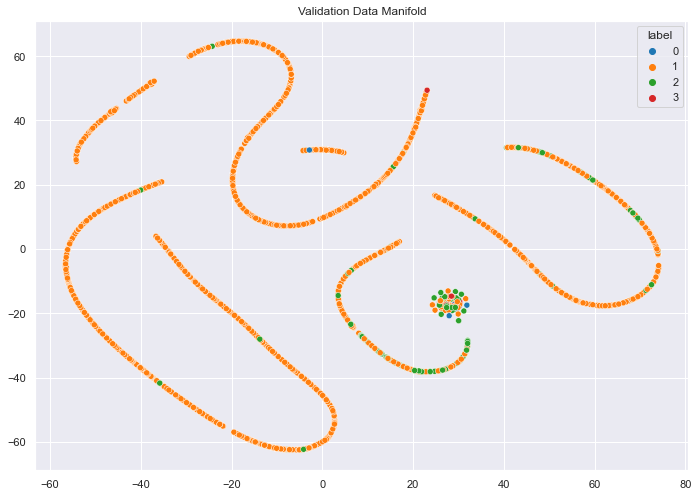

In [64]:
sns.scatterplot(x=encoded_valid_tsne[:,0],
                y=encoded_valid_tsne[:,1],
                hue=y_valid_labels, 
                legend='full', 
                palette="tab10").set_title('Validation Data Manifold');

In [65]:
res = pd.DataFrame(zip(clf.predict(valid_encoded_df), y_valid_labels), columns=["pred", "true"])

In [66]:
(res["pred"] == res["true"]).sum() / len(res)

0.9014263074484945

In [67]:
res

,pred,true
0,1,1
1,1,2
2,1,1
3,1,1
4,1,1
...,...,...
3150,1,1
3151,1,1
3152,1,1
3153,1,2


In [68]:
from sklearn.metrics import precision_recall_fscore_support as multiclass_eval

prec, recall, fbeta, _ = multiclass_eval(res["true"].values, res["pred"].values, average="macro")

f"precision {prec}, recall {recall}, fbeta {fbeta}"

'precision 0.33341746002813566, recall 0.32497690175546656, fbeta 0.3286400048920687'

In [69]:
# import umap
# import matplotlib.pyplot as plt

# reducer = umap.UMAP()

# embedding = reducer.fit_transform(valid_encoded_df.values)
# embedding.shape

# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=[sns.color_palette()[x] for x in y_valid_labels.values])

# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the LC Loans', fontsize=24)